In [1]:
import numpy as np
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel
import pandas as pd
from nilearn import plotting, image
from nilearn.masking import compute_epi_mask, intersect_masks
from tmfc_py.gppi_regressors_utils import extract_vois_from_clean_img, _extract_single_mask_time_series
from tmfc_py.matlab_utils import convert_3d_to_4d_fmri
from pathlib import Path
from nilearn.plotting import plot_design_matrix
from tmfc_py.first_level_utils import (create_motion_confounds_from_rp,
                                       create_design_matrix,
                                       fit_first_level_glm_with_dm,
                                    )
from tmfc_py.gppi_regressors_utils import _load_nifti
%load_ext autoreload

In [2]:
REAL_DATA_PATH = Path.cwd().parent/ "data" / "raw"/"01_Sub"
conf_folder = str(REAL_DATA_PATH / "swar" / "02_Run")
events_filename = str(REAL_DATA_PATH / "sots" / "02_Run_06_Deriv_[fix_onset]_[700ms_dur].csv")
events_df = pd.read_csv(events_filename, sep='\t')

## First step: clean image and save

for further voi extraction include_events  - non intersting events included as regressors


In [3]:
conf_df = create_motion_confounds_from_rp(conf_folder, n_params=6)
dm = create_design_matrix(events_df,
                              conf_df,
                              include_events=['Nuisance'],
                              n_vols=conf_df.shape[0])
run_imgs = convert_3d_to_4d_fmri(conf_folder)
resids = fit_first_level_glm_with_dm(run_imgs,
                                     dm,
                                     noise_model = 'ar1',
                                     return_residuals=True)
nibabel.save(resids[0], "../data/interim/cleaned_vois_2run6p_ar.nii.gz")

/Users/irinaknyazeva/Yandex.Disk.localized/Projects/BrainIHBProjects/LabNeuroimagingProjects/TMFC/TMFCpy/tmfc_py/first_level_utils.py:158: UserWarning: If design matrices are supplied, [high_pass, hrf_model, slice_time_ref, t_r] will be ignored.
  flm.fit(run_imgs=run_imgs, design_matrices=design_matrices)


[FirstLevelModel.fit] Loading data from Nifti1Image(
shape=(53, 63, 52, 231),
affine=array([[  -3.,    0.,    0.,   78.],
       [   0.,    3.,    0., -112.],
       [   0.,    0.,    3.,  -70.],
       [   0.,    0.,    0.,    1.]])
)

[FirstLevelModel.fit] Computing the mask

[FirstLevelModel.fit] Resampling mask

[FirstLevelModel.fit] Finished fit

[FirstLevelModel.fit] Computing run 1 out of 1 runs (go take a coffee, a big one).

[FirstLevelModel.fit] Performing mask computation.

[FirstLevelModel.fit] Loading data from Nifti1Image(
shape=(53, 63, 52, 231),
affine=array([[  -3.,    0.,    0.,   78.],
       [   0.,    3.,    0., -112.],
       [   0.,    0.,    3.,  -70.],
       [   0.,    0.,    0.,    1.]])
)

[FirstLevelModel.fit] Extracting region signals

[FirstLevelModel.fit] Cleaning extracted signals

[FirstLevelModel.fit] Masking took 1 seconds.

[FirstLevelModel.fit] Performing GLM computation.

[FirstLevelModel.fit] GLM took 1 seconds.

[FirstLevelModel.fit] Computation of 1 runs done in 3 seconds.

## Masking
Разбираемся с масками
По базовым маскам есть различия по краю, довольно большие
Основной вопрос для VOI:
 - как в обработанной маске для VOI может быть больше вокселей, чем в сырой?

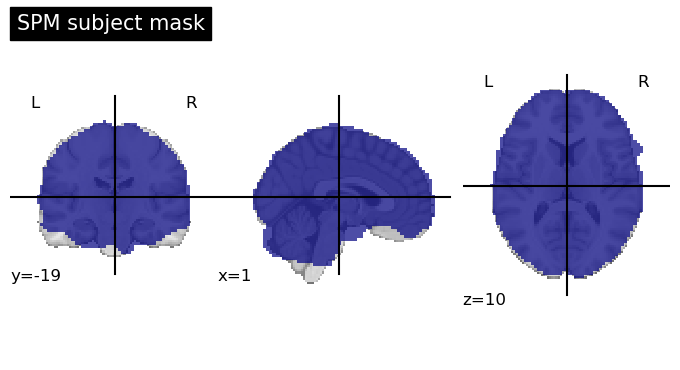

In [8]:
spm_mask_path = REAL_DATA_PATH/'struct'/'mask.nii'
spm_mask = _load_nifti(spm_mask_path)
plotting.plot_roi(spm_mask_path ,  colorbar=False, title = 'SPM subject mask');


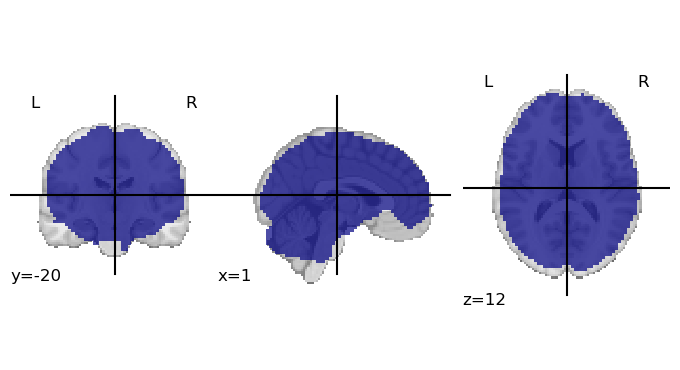

In [9]:
mask_img = compute_epi_mask(run_imgs, lower_cutoff=0.25, upper_cutoff=0.85)
plotting.plot_roi(mask_img,  colorbar=False)

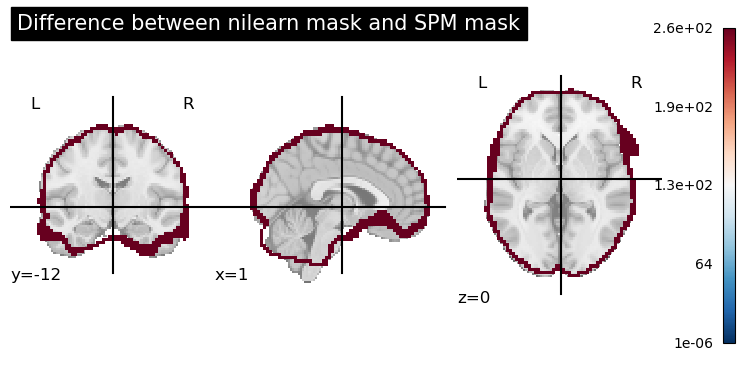

In [10]:
difference_img = image.math_img("img1 - img2", img1=mask_img, img2=spm_mask_path)
plotting.plot_stat_map(
    difference_img,
    title="Difference between nilearn mask and SPM mask",
    display_mode="ortho",
    cut_coords=None  # Let nilearn choose the coordinates
);

## VOI extraction

In [11]:
VOI_NAME = '001_L_V1'
CLEAN_IMG_PATH = str(Path.cwd().parent/'data'/'interim'/'cleaned_vois_2run6p_ar.nii.gz')
VOI_MASK_PATH_RAW = str(Path.cwd().parent/'data'/'raw'/'ROIsMasks'/'01_HCPex'/f'{VOI_NAME}.nii')
VOI_MASK_PATH_MASKED = str(Path.cwd().parent/'data'/'external'/'01_Sub'/'MaskedRois'/f'{VOI_NAME}_masked.nii')

In [12]:
cleaned_img = _load_nifti(CLEAN_IMG_PATH)
voi_mask_raw = _load_nifti(VOI_MASK_PATH_RAW)
voi_masked_spm = _load_nifti(VOI_MASK_PATH_MASKED)


In [13]:
mean_clean_img = image.math_img('img.mean(axis=3)', img=cleaned_img)
#plotting.plot_roi(mask_img, mean_clean_img, colorbar=False);
#resampling to run_images affine
voi_mask_raw = image.resample_to_img(voi_mask_raw, run_imgs, interpolation= 'nearest', copy_header=True, force_resample=True)

In [14]:
print("Num vox in raw mask: ", voi_mask_raw.get_fdata().sum())
print("Num vox in spm voi mask mask: ", voi_masked_spm.get_fdata().sum())

Num vox in raw mask:  481.00002844585106
Num vox in spm voi mask mask:  593.0000350694172


Num vox in raw voi mask after applying nilearn computed mask:  330.0


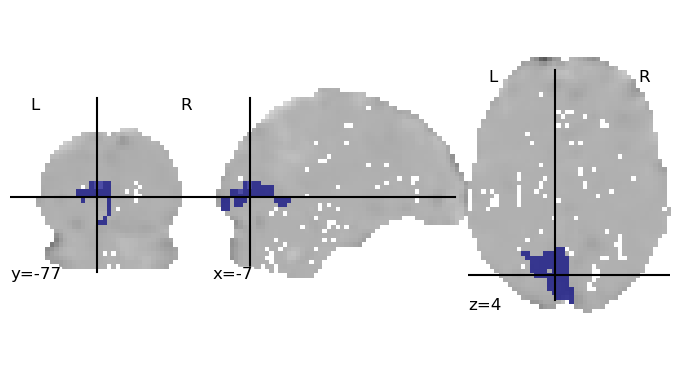

In [15]:
#after intersection with nilearn mask
voi_masked_nilearn = intersect_masks([voi_mask_raw, mask_img], threshold=0.5)
print("Num vox in raw voi mask after applying nilearn computed mask: ", voi_masked_nilearn.get_fdata().sum())
plotting.plot_roi(voi_masked_nilearn, mean_clean_img, colorbar=False);


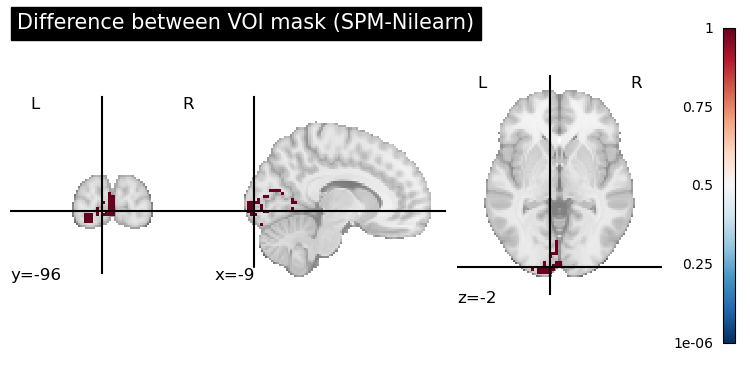

In [16]:
diff_voi_mask = image.math_img("img1 - img2", img1=voi_masked_spm, img2=voi_masked_nilearn)
plotting.plot_stat_map(
    diff_voi_mask,
    title="Difference between VOI mask (SPM-Nilearn)",
    display_mode="ortho",
    cut_coords=None  # Let nilearn choose the coordinates
);

In [17]:
VOI_SERIES_SPM = Path.cwd().parent/'data'/'external'/'01_Sub'/'VOIs'/f'VOI_{VOI_NAME}_1.mat'
time_series_spm = sio.loadmat(str(VOI_SERIES_SPM))['Y'].squeeze()
time_series_nilearn = _extract_single_mask_time_series(cleaned_img, voi_masked_spm, agg='eig')
time_series_nilearn_own_mask = _extract_single_mask_time_series(cleaned_img, voi_masked_nilearn, agg='eig')


In [18]:
#np.std(time_series_nilearn), np.std(time_series_spm), np.std(time_series_nilearn_own_mask)
np.corrcoef(time_series_nilearn, time_series_spm)[0,1], np.corrcoef(time_series_nilearn_own_mask, time_series_spm)[0,1]


(np.float64(0.5674862522953574), np.float64(0.653787631220047))

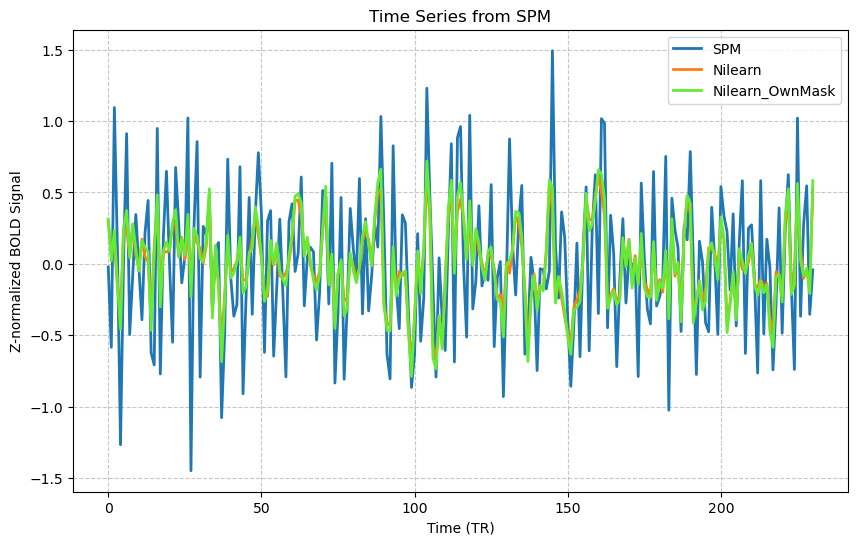

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(time_series_spm, label='SPM', color='#1f77b4', linewidth=2)  # Blue
plt.plot(time_series_nilearn, label='Nilearn', color='#ff7f0e', linewidth=2) # Orange
plt.plot(time_series_nilearn_own_mask, label='Nilearn_OwnMask', color='#64eb34', linewidth=2)  # Orange

plt.xlabel('Time (TR)')
plt.ylabel('Z-normalized BOLD Signal')
plt.title('Time Series from SPM')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)